In [4]:
%matplotlib inline
# Import Qiskit classes
import qiskit 
from qiskit import QuantumRegister, QuantumCircuit
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *

# Loading your IBM Q account(s)
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2020-05-28 14:43:39,995: Credentials are already in use. The existing account in the session will be replaced.


 # 1
 1) Przygotowanie "pustego" obwodu na podstawie którego sprawdzimy szum, o parametrach odpowiadających 
 obwodowi, który chcemy skorygować.
 2) Tworzym 2^n (lość mierzonych kubitów) obwody kalibracyjne, z których każdy tworzy stan bazowy.
 3) Uruchamiamy otrzymane obwody kalibracyjne na wybranym realnym komputerze kwantowym.
 4) Na podstawie otrzymanych wyników wyliczamy macierz kalibracji.
 5) Uruchamiamy na dowolnym realnym komputerze kwontowym układ, który chcemy skorygować.
 6) Na otrzymany wynik aplikujemy otrzymaną wcześniej macierz kalibracji w celu poprawienia jakości wyników.
 
 # 2
Realizowanie na podstawie LAB 10 - Algorytm Groovera


In [12]:
# 1)
qr = qiskit.QuantumRegister(3)
qubit_list = [0,1]
# 2)
meas_calibs, state_labels = complete_meas_cal(qubit_list=qubit_list, qr=qr, circlabel='mcal')
print(state_labels)

['00', '01', '10', '11']


In [19]:
# 3)
backend = provider.get_backend('ibmq_burlington')
job = qiskit.execute(meas_calibs, backend=backend, shots=1000)
cal_results = job.result()

In [20]:
# 4)  
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
print(meas_fitter.cal_matrix)

[[0.944 0.085 0.152 0.036]
 [0.024 0.88  0.011 0.157]
 [0.021 0.003 0.815 0.06 ]
 [0.011 0.032 0.022 0.747]]


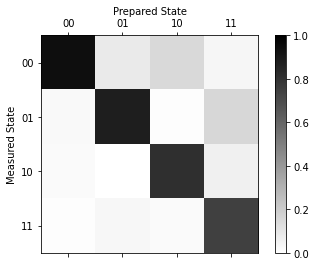

In [21]:
meas_fitter.plot_calibration()

In [16]:
#przykład książkowy - obwód
circ = QuantumCircuit(3,2)

# for |00>
circ.x(2)
circ.barrier()
circ.h([0,1,2])
circ.ccx(0,1,2)
circ.h([0,1])
circ.x([0,1])
circ.barrier()
circ.h(1)
circ.cx(0,1)
circ.h(1)
circ.barrier()
circ.x([0,1])
circ.h([0,1])

circ.barrier()
circ.measure([0,1],[0,1])

circ.draw()

In [23]:
#5)
job = qiskit.execute(ghz, backend=backend, shots=5000)
results = job.result()
raw_counts = results.get_counts()

In [24]:
meas_filter = meas_fitter.filter

#6)
mitigated_results = meas_filter.apply(results)
mitigated_counts = mitigated_results.get_counts(0)

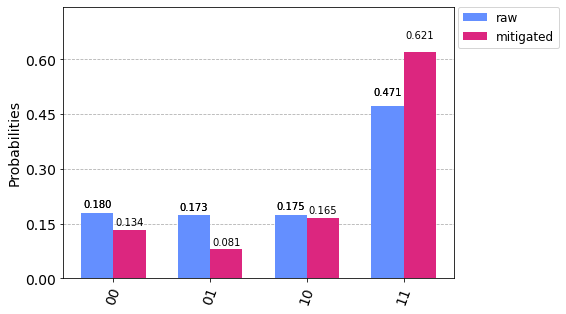

In [25]:
plot_histogram([raw_counts, mitigated_counts], legend=['raw', 'mitigated'])

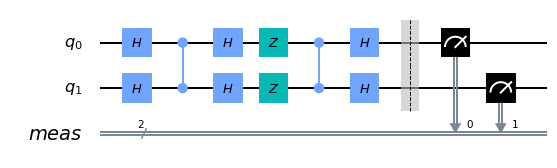

In [30]:
#przykład IBM zoptymalizowany - obwód
circ_opt = QuantumCircuit(2)

circ_opt.h([0,1])
circ_opt.cz(0,1)
circ_opt.h([0,1])
circ_opt.z([0,1])
circ_opt.cz(0,1)
circ_opt.h([0,1])
circ_opt.measure_all()
circ_opt.draw()

In [31]:
#5)
job_opt = qiskit.execute(circ_opt, backend=backend, shots=5000)
results_opt = job.result()
raw_counts_opt = results_opt.get_counts()

In [32]:
#6)
mitigated_results_opt = meas_filter.apply(results)
mitigated_counts_opt = mitigated_results.get_counts(0)

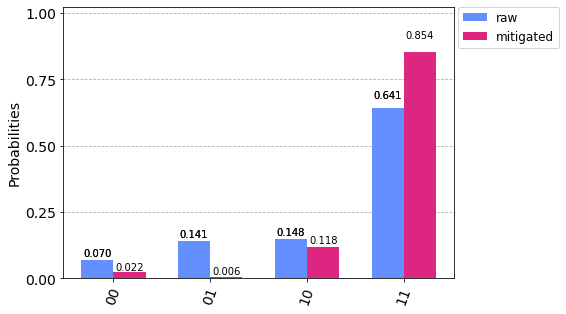

In [33]:
plot_histogram([raw_counts_opt, mitigated_counts_opt], legend=['raw', 'mitigated'])

# 3
Zarówno dla książkowego jak i zoptymalizowanego przykładu implementacji algorytmu Groovera jakość otrzymanych wyników uległa poprawie, co można zaobserwować na histogramach (widzimi wzrost trafien w wynik poprawny 11 i spadek przy wersjach błędnych). Poprawa może wynikać z pozbycia się szumu wynikającego z samego zastosowania pomiaru.